In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc

In [3]:
grids = [(5,5), (8,8), (10,10), (12,12), (15,15)]

In [4]:
def drawPlot(grids, n, d, e):
    regrets, elapses = getRow(grids, n, d, e)
    # color map
    cset =  tc.tol_cset('light')
    colors = [cset.mint, cset.pink, cset.orange, cset.light_blue]
    # x tick
    x = np.array([i for i in range(len(grids))])
    # time
    fig = plt.figure(figsize=(16, 8))
    c = colors[0]
    plt.plot(x, elapses["lr"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x+0.012, elapses["lr"]["mean"], elapses["lr"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    c = colors[1]
    plt.plot(x, elapses["rf"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x-0.012, elapses["rf"]["mean"], elapses["rf"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    c = colors[2]
    plt.plot(x, elapses["spo"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x-0.004, elapses["spo"]["mean"], elapses["spo"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    c = colors[3]
    plt.plot(x, elapses["bb"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x+0.004, elapses["bb"]["mean"], elapses["bb"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    plt.ylim(0, 3500)
    plt.xticks(x, labels=["{}x{}".format(g[0], g[1]) for g in grids], fontsize=28)
    plt.yticks(fontsize=24)
    plt.xlabel("Graph Size", fontsize=36)
    plt.ylabel("Time (Sec)", fontsize=36)
    plt.title("Runtime\nTraining Set Size = {}, Polynomial Degree = {}, Noise Half−width = {}".format(n,d,e),
              fontsize=30)
    plt.legend(["2-stage LR", "2-stage RF", "SPO+","DBB"], fontsize=24, ncol=2)
    plt.show()
    fig.savefig("./images/scale-sp-n{}d{}e{}-time.pdf".format(n,d,int(10*e)), dpi=300)
    # loss
    fig = plt.figure(figsize=(16, 8))
    c = colors[0]
    plt.plot(x, regrets["lr"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x+0.012, regrets["lr"]["mean"], regrets["lr"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    c = colors[1]
    plt.plot(x, regrets["rf"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x-0.012, regrets["rf"]["mean"], regrets["rf"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    c = colors[2]
    plt.plot(x, regrets["spo"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x-0.004, regrets["spo"]["mean"], regrets["spo"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    c = colors[3]
    plt.plot(x, regrets["bb"]["mean"], linewidth=5, color=c, alpha=0.6)
    plt.errorbar(x+0.004, regrets["bb"]["mean"], regrets["bb"]["std"], capsize=6, capthick=3,
                 linestyle="", marker="o", markersize=8, color=c, elinewidth=3, alpha=0.6)
    plt.ylim(0, 0.2)
    plt.xticks(x, labels=["{}x{}".format(w,h) for w,h in grids], fontsize=28)
    plt.yticks(fontsize=24)
    plt.xlabel("Graph Size", fontsize=36)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.title("Loss\nTraining Set Size = {}, Polynomial Degree = {}, Noise Half−width = {}".format(n,d,e),
              fontsize=30)
    plt.legend(["2-stage LR", "2-stage RF", "SPO+","DBB"], fontsize=24, ncol=2)
    plt.show()
    fig.savefig("./images/scale-sp-n{}d{}e{}-loss.pdf".format(n,d,int(10*e)), dpi=300)

In [5]:
def getRow(grids, n, d, e):
    regrets = {"lr":{"mean":[],"std":[]}, "rf":{"mean":[],"std":[]}, "spo":{"mean":[],"std":[]}, "bb":{"mean":[],"std":[]}}
    elapses = {"lr":{"mean":[],"std":[]}, "rf":{"mean":[],"std":[]}, "spo":{"mean":[],"std":[]}, "bb":{"mean":[],"std":[]}}
    for g in grids:
        l, t = getData(g, n, d, e)
        for m in regrets:
            regrets[m]["mean"].append(l[m]["mean"])
            regrets[m]["std"].append(l[m]["std"])
            elapses[m]["mean"].append(t[m]["mean"])
            elapses[m]["std"].append(t[m]["std"])
    return regrets, elapses

In [6]:
def getData(grid, n, d, e):
    # dir
    dir_name = "./res/sp/h{}w{}/gurobi".format(grid[0], grid[1])
    file_name = {}
    file_name["lr"] = "n{}p5-d{}-e{}_2s-lr.csv".format(n,d,e)
    file_name["rf"] = "n{}p5-d{}-e{}_2s-rf.csv".format(n,d,e)
    file_name["spo"] = "n{}p5-d{}-e{}_spo_lr_adam0.001_bs32_l10.0l20.0_c8.csv".format(n,d,e)
    file_name["bb"] = "n{}p5-d{}-e{}_bb_lr_adam0.01_bs128_l10.0l20.0_c8-lamb20.csv".format(n,d,e)
    # load data
    regret, elapse = {}, {}
    for m, f in file_name.items():
        df = pd.read_csv(dir_name + "/" + f)
        regret[m] = {"mean":df["Unamb SPO"].mean(), "std":df["Unamb SPO"].std()}
        elapse[m] = {"mean":df["Elapsed"].mean(), "std":df["Elapsed"].std()}
    return regret, elapse

## Deg = 2 

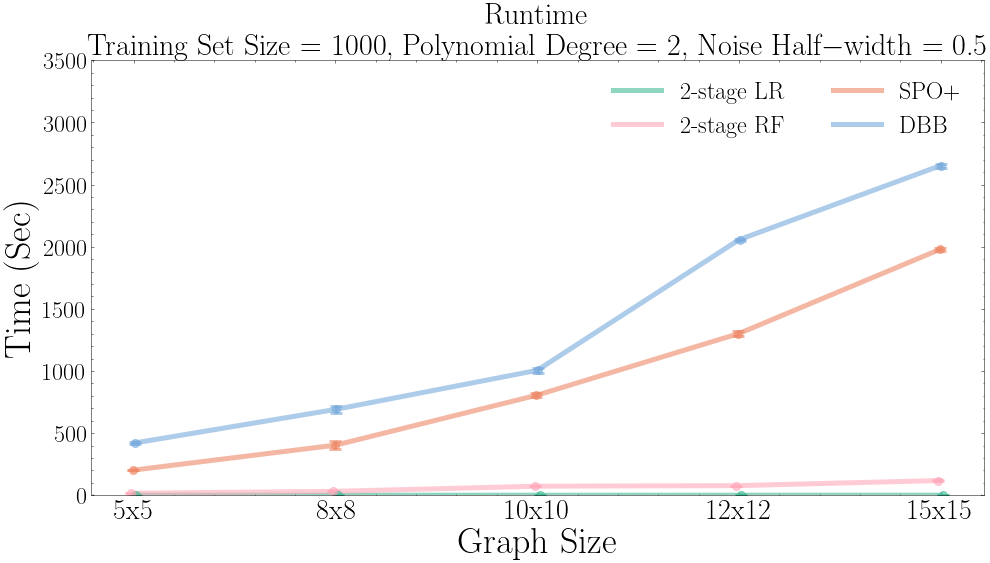

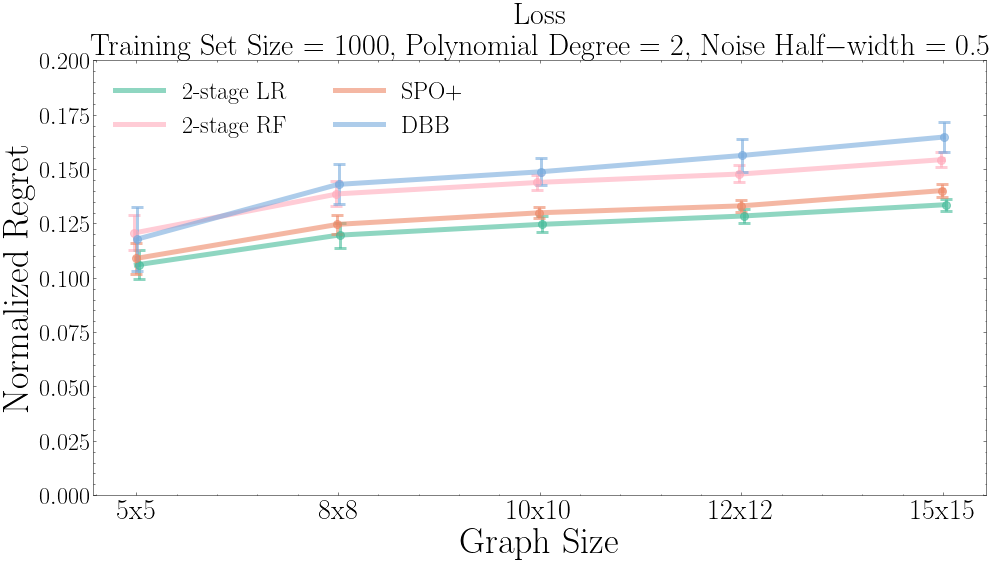

In [7]:
n = 1000
d = 2
e = 0.5
drawPlot(grids, n, d, e)

## Deg = 4 

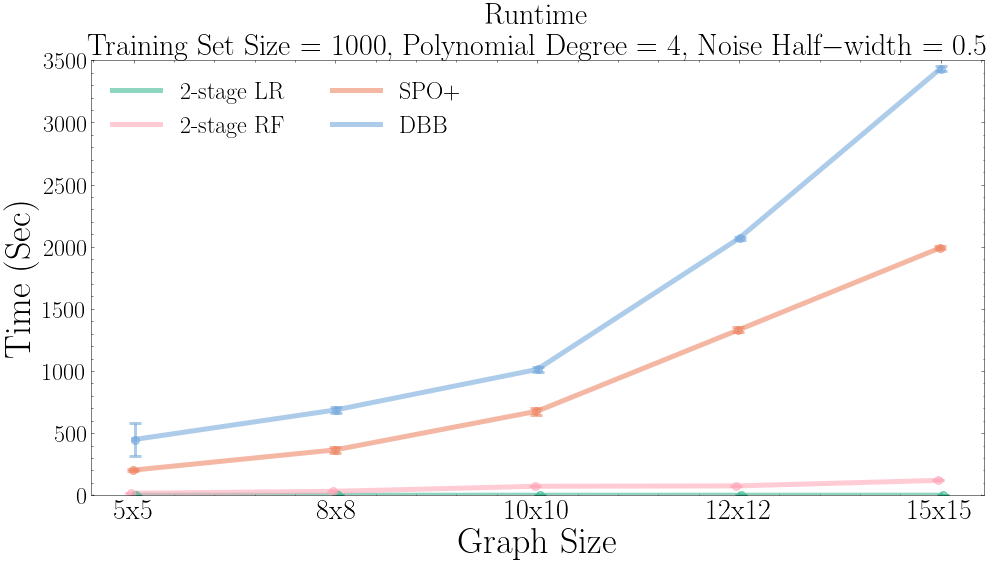

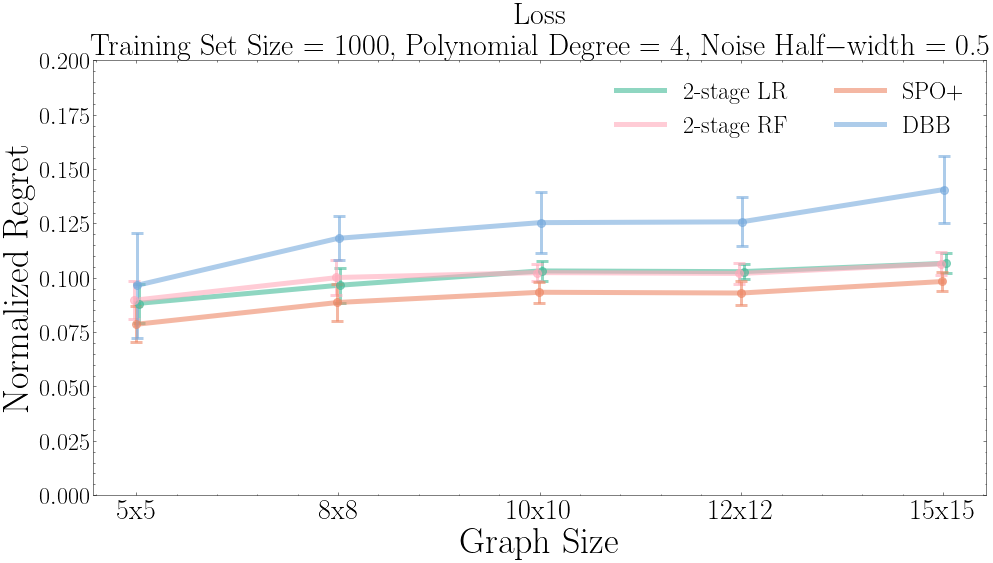

In [8]:
n = 1000
d = 4
e = 0.5
drawPlot(grids, n, d, e)